In [2]:
#How to Sample a multi-dimensional Gaussian

import numpy as np
import emcee

def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

#The first arguement of the probability function is the position of a single 
#walker (a N dimensional numpy array)

#Setting up specific values of hyperparameters in 5 dimensions
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [3]:
#We are going to do the followiing with 32 walkers 

#We need to guess a "starting point for the walkers"

#the position will be a 5-dimensional vector, so we will guess
# guess a 32 by 5 array.
nwalkers = 32 
p0 = np.random.rand(nwalkers, ndim)



In [4]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

log_prob(p0[0], means, cov)

-2.5960945890854434

In [5]:
#Before letting our walkers loose in the MCMC chain, we should designate a few 
#"burn-in" steps. burn-in steps are steps in the MCMC chain that we intentially
#discard because our walkers have not settled into the parameter space.
#The number of required burn-in steps is hard to predict.


state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(state, 10000)

State([[-0.43424014  1.78803091  0.75224634  0.65915817  0.4734423 ]
 [-0.71238895  0.73426195  1.61712787  0.01255936 -0.88053699]
 [-0.12594128  1.35599541  1.45238318  0.67980103  0.04012247]
 [ 0.61314205  0.05575063  0.08529774  0.33867444 -0.50362248]
 [-0.43664707  0.80436207  1.13204378  0.09380783 -0.86993763]
 [ 0.46853993  0.33075848  1.3573585   0.6343816  -0.06090445]
 [ 1.33160321  0.85641285  0.24891645  0.60504798  0.31227906]
 [-0.01892609 -0.69794138  0.75504743  0.57176373 -0.56125437]
 [ 0.10126089  0.83103772  0.41637254  1.19650469  0.94380252]
 [ 0.77011537  1.04838809  0.34784618  0.23919228 -0.68069185]
 [ 0.34249082  1.74170469  0.2715152   0.44037013  0.33070086]
 [ 0.63990461  0.20794172  0.55347742  0.50262532  0.59795591]
 [-0.61191978  0.87287941  0.72937147  0.46822771 -0.10662417]
 [ 1.3868385   1.24258573  0.42448945  0.96352562  0.7483911 ]
 [ 0.23483736  0.92491094  0.7886009   0.5403674  -0.20953847]
 [ 0.79224679  2.26723672  0.59926754  0.05649208

[]

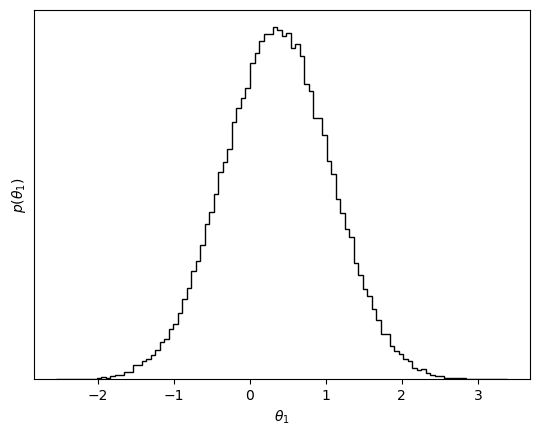

In [6]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([])

In [7]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)


Mean acceptance fraction: 0.552


Text(0, 0.5, 'd$\\sigma$/dE$_{r}$')

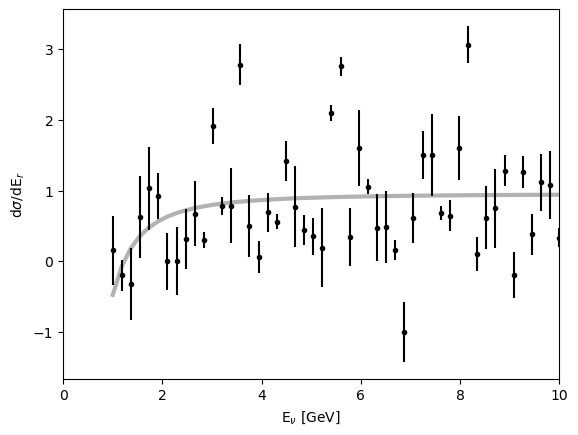

In [62]:
#Fitting a model to noisy data
#Here we are fitting a line to data when we don't believe the errors bars 
#on our data.
import math 
np.random.seed(13)

# Choose the "true" parameters.
m_N = 3
G_F = 1.0
E_r = 1
Q_w = 1

# Generate some synthetic data from the model.
N = 50
#x = np.sort(10 * np.random.rand(N))
x = np.linspace(1, 10, 50)
yerr = 0.1 + 0.5 * np.random.rand(N)

y = ((m_N*G_F**2)/(2*math.pi))*(2-E_r*m_N/(x**2))*(Q_w**2)

y += np.abs(E_r * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

#The graph below is off our noisy data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

#The graph below is of our model
x0 = np.linspace(1, 10, 50)
plt.plot(x0, ((m_N*G_F**2)/(2*math.pi))*(2-E_r*m_N/(x0**2))*(Q_w**2), "k", alpha=0.3, lw=3)

#We are plotting this grey line on top of our data points to help visualize
#just how much we are underestimating the uncertainites in our data.

plt.xlim(0, 10)

#plt.yscale('log')
plt.xlabel(r"E$_{\nu}$ [GeV]")
plt.ylabel(r"d$\sigma$/dE$_{r}$")
#plt.ylabel(r"d$\Phi_{\nu_{\mu}}$/dE$_{\nu}$")



Least-squares estimates:
m = 0.019 ± 0.014
b = 0.788 ± 0.084


Text(0, 0.5, 'd$\\sigma$/dE$_{r}$')

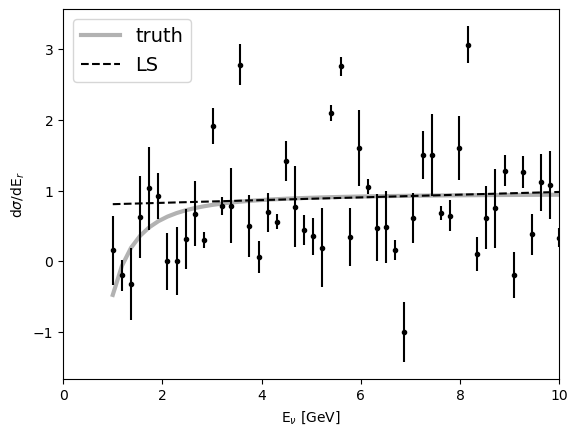

In [64]:
#Now we are going to fit the noise to our model by using the method of least 
#squares. We choose this method over methods because solving for parameters and 
#their uncertainties is very simple.

#I'm taking a short aside to *briefly* discuss the method of least squares. The 
#idea is to reduce the sum of the squares of the residual points from the curve
#and "least square" will be the model that best follows the general trend
#of the data.



A = np.vander(x, 2)
#np.vander generates a vandermonde matrix
#Example:
#VandermondeMatrix = np.vander([1,2,3],3)
#  
#print (VandermondeMatrix)
#
#[[ 1  1  1]    <-Start with 1 and multiply each by powers by one
# [ 4  2  1]    <-Start with 1 and multiply each by powers of two
# [ 9  3  1]]    <-Start with 1 and multiply each by powers of three

C = np.diag(yerr * yerr)
#np.diag generates an array that are the diaganal elements of a matrix
#a = np.matrix([[1, 2, 3], [4, 5, 6], [9, 8, 7]])
#np.diag(a)
#
#[1,5,7]


ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

#Ploting our noise data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#Ploting our model
plt.plot(x0, ((m_N*G_F**2)/(2*math.pi))*(2-E_r*m_N/(x0**2))*(Q_w**2), "k", alpha=0.3, lw=3, label="truth")
#Plotting our fit using the method of least squares
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
#plt.yscale('log')
plt.xlabel(r"E$_{\nu}$ [GeV]")
plt.ylabel(r"d$\sigma$/dE$_{r}$")



Maximum likelihood estimates:
m_n = 432.827
G_F = 173.366
E_r = 0.007
Q_w = 0.000


Text(0, 0.5, 'd$\\sigma$/dE$_{r}$')

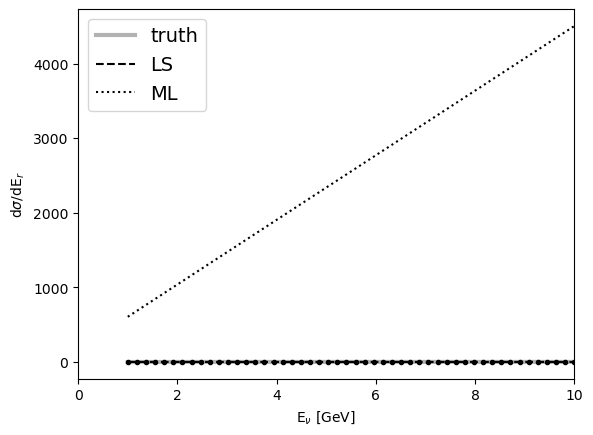

In [65]:
#Maximum Likelihood
#What we want to do here is maximize a likelihood function so that under our
#assumed statitiscal model, the observed data is the most probabily

#This is the likelihood function
def log_likelihood(theta, x, y, yerr):
    m, G, E, Q = theta
    model = ((m*G**2)/(2*math.pi))*(2-E*m/(x**2))*(Q**2)
    sigma2 = yerr**2 + model**2 * np.exp(2 * Q)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) 


#scipy.optimize is a python package that contains commonly used optimization 
#algorithms
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_N, G_F, E_r, Q_w]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, G_ml, E_ml, Q_ml = soln.x


print("Maximum likelihood estimates:")
print("m_n = {0:.3f}".format(m_ml))
print("G_F = {0:.3f}".format(G_ml))
print("E_r = {0:.3f}".format(E_ml))
print("Q_w = {0:.3f}".format(Q_ml))



plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, ((m_N*G_F**2)/(2*math.pi))*(2-E_r*m_N/(x0**2))*(Q_w**2), "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, G_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel(r"E$_{\nu}$ [GeV]")
#plt.yscale('log')
plt.ylabel(r"d$\sigma$/dE$_{r}$")


You must install the tqdm library to use progress indicators with emcee


[[4.32826486e+02 1.73365849e+02 7.33331497e-03 4.35955782e-04]
 [4.32826523e+02 1.73365989e+02 7.12058094e-03 6.23049467e-04]
 [4.32826448e+02 1.73365953e+02 7.04197364e-03 3.21542112e-04]
 [4.32826449e+02 1.73365930e+02 7.07329048e-03 3.84302265e-04]
 [4.32826370e+02 1.73365925e+02 6.96574866e-03 5.29549960e-04]
 [4.32826519e+02 1.73365788e+02 7.08529979e-03 3.78328723e-04]
 [4.32826542e+02 1.73366068e+02 6.92870345e-03 4.65046971e-04]
 [4.32826494e+02 1.73366001e+02 7.13754036e-03 3.78347430e-04]
 [4.32826479e+02 1.73365854e+02 7.22382141e-03 4.55675528e-04]
 [4.32826701e+02 1.73365928e+02 7.04538002e-03 3.02172924e-04]
 [4.32826330e+02 1.73365775e+02 7.14293336e-03 5.04416866e-04]
 [4.32826352e+02 1.73366023e+02 7.06791459e-03 4.68223664e-04]
 [4.32826672e+02 1.73366023e+02 7.08936763e-03 3.64425141e-04]
 [4.32826295e+02 1.73365862e+02 7.09510768e-03 3.54826411e-04]
 [4.32826497e+02 1.73365941e+02 7.09373510e-03 3.88544105e-04]
 [4.32826527e+02 1.73365978e+02 7.00718079e-03 5.946376

Text(0.5, 0, 'step number')

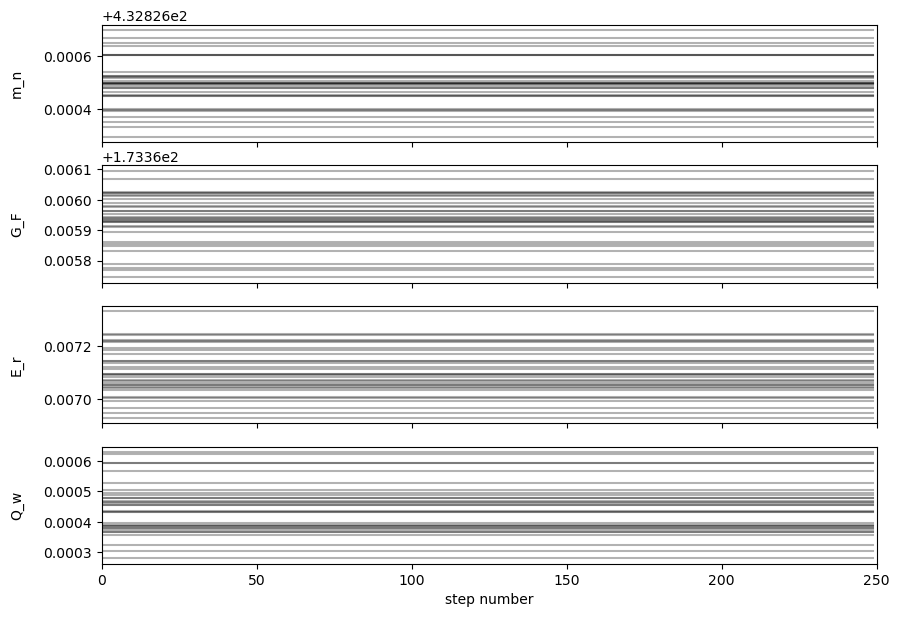

In [80]:
#Marginalization and Uncertianty Estimation

#MCMC are useful to us in physics becausse they allow us to marganlize over
#nuisance parameters and estimate the postior proabbility function.


#We need to write down pripors if we are going to use MCMC because the MCMC
#draws samples from a probability distribution and we want that to be a 
#probability distribution for our parameters.

#Important: WE CANNOT DRAW PARAMETER SAMPLES FROM OUR LIKELYHOOD FUNCTION.
#What we CAN do is use the likelihood function to draw representative datasets.

#The tutorial example has us use uniform ("uninformative") priors on m, b, and
#the logarithm of f.


def log_prior(theta):
    m, G, E, Q = theta
    if 0.5 < m < 0.5 and 0.0 < G < 5.0 and 0.0 < E < 0.5 and 0.0 < Q < 0.5:
        return 0.0
    return -np.inf

#Defining the full log-probability function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

#Now, we are going to sample the above distribution using emcee. The tutorial
#recommends initialzing the walkers in a tiny Gaussian ball aroudn the maximum
#likelihood result


#m_n = 432.827
#G_F = 173.366
#E_r = 0.007
#Q_w = 0.000

pos = soln.x + 1e-4 * np.random.randn(32, 4)
print(pos)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 250, progress=True)

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples)
labels = ["m_n", "G_F", "E_r","Q_w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#The graph below shows the position of each walker as a function as the number
#of steps in the chain. If you look at the first 25-ish steps you will see that
#the walkers are hanging around the maximum likelihood values. This isn't 
#optimal because this means that walkers haven't fully explored the posterior
#distribution yet. To borrow a word a I used previously, this means that walkers
#are not yet "burn-in" as of step 25-ish. So later on, we should set our burn-in
#steps to 100, so that we are confident that our walkers have had the chance to 
#explore the ful posterior distribution.

You must install the tqdm library to use progress indicators with emcee


Text(0.5, 0, 'step number')

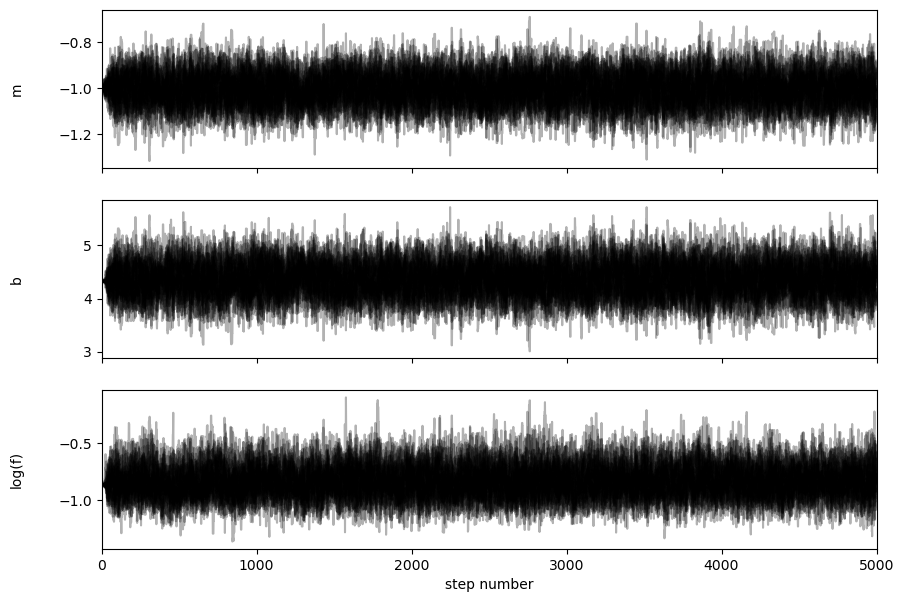

In [14]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [17]:
tau = sampler.get_autocorr_time()
#The results suggest that it takes about 40 steps for the chain to "forget" 
#where it started.
print(tau)

#Now we are going to do discard the first 100 steps of the chain because of 
#burn-in
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)


[40.1098185  40.77016147 39.43097769]
(10432, 3)


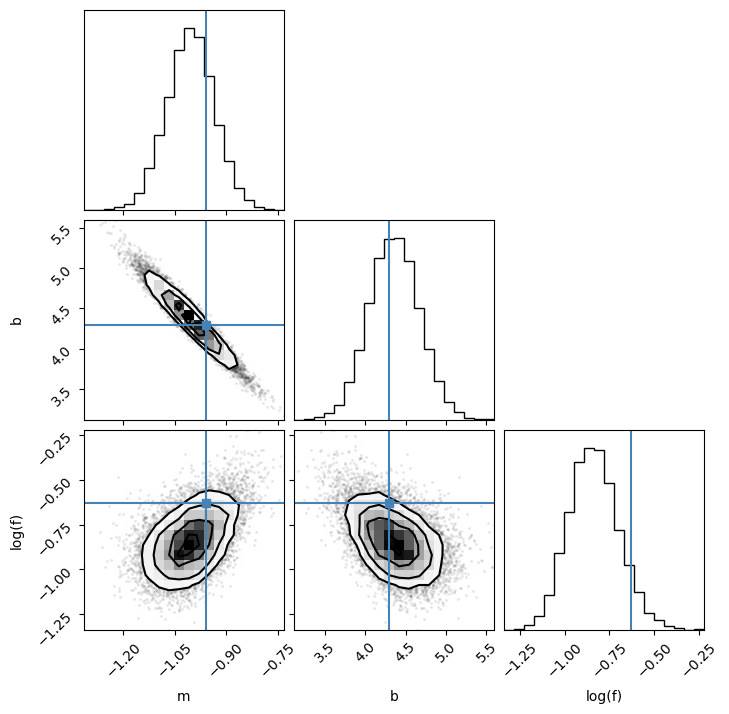

In [18]:
#Finally we can graph our results. These plots show 1-D and 2-D projections 
#of the posterior probability distributions of our parameters. This is helpful
#because it demonstrates the correlations between parameters.

import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)

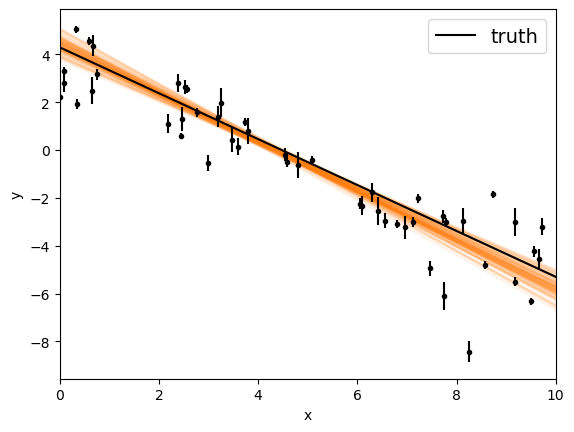

In [19]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [20]:
from IPython.display import display, Math

#Now we have uncertainites that we can better trust. These uncertainites are 
#based on the 16th, 50th, and 84th percentiles of the samples in the marginalized
#distributions.

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>